In [8]:
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import optuna, tqdm
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('Employee.csv').drop(columns=["City"])
df['Education'] = pd.factorize(df['Education'])[0]
df['Gender'] = pd.factorize(df['Gender'])[0]
df['EverBenched'] = pd.factorize(df['EverBenched'])[0]
df

,Education,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,0,2017,3,34,0,0,0,0
1,0,2013,1,28,1,0,3,1
2,0,2014,3,38,1,0,2,0
3,1,2016,3,27,0,0,5,1
4,1,2017,3,24,0,1,2,1
...,...,...,...,...,...,...,...,...
4648,0,2013,3,26,1,0,4,0
4649,1,2013,2,37,0,0,2,1
4650,1,2018,3,27,0,0,5,1
4651,0,2012,3,30,0,1,2,0


In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['LeaveOrNot']))
y = df['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [11]:
class KNN:
    def __init__(self, metric='euclidean', kernel="uniform", fix_window=False, window_param: int=30, weights=None):
        self.metric = metric
        self.weights = weights
        self.kernel = kernel
        self.fix_window = fix_window
        self.window_param = window_param
        self.nn = NearestNeighbors(metric=self.metric)

    def _distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.linalg.norm(x1 - x2)
        elif self.metric == 'cosine':
            return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
        elif self.metric == 'chebyshev':
            return np.max(np.abs(x1 - x2))

    def _kernel(self, d):
        if self.kernel == 'uniform':
            return 1 / 2 * (d < 1)
        elif self.kernel == 'gaussian':
            return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * d**2)
        elif self.kernel == 'triang':
            return (1 - abs(d)) * (d < 1)
        elif self.kernel == 'cosine':
            return np.dot(d, d) / (np.linalg.norm(d) * np.linalg.norm(d))

    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        self.nn.fit(X_train)

    def predict(self, X_test):
        y_pred = []
        prob_list = []
        for x_test in X_test:
            self.weights = np.ones(self.X_train.shape[0]) if self.weights is None else np.array(self.weights)

            if self.fix_window:
                radius = np.inf if self.kernel == "gaussian" else self.window_param
                dists, indices = self.nn.radius_neighbors(X=np.array([x_test]), radius=radius)
            else:
                dists, indices = self.nn.kneighbors(X=np.array([x_test]), n_neighbors=self.window_param + 1)

            dists, indices = dists[0], indices[0]
            dists = dists / (self.window_param if self.fix_window else dists[-1])

            ker = self._kernel(dists) * self.weights[indices]

            class_labels  = self.Y_train[indices]
            sum_of_ker_per_class = np.bincount(class_labels, weights=ker, minlength=len(np.unique(self.Y_train)))
            sum = sum_of_ker_per_class.sum()
            prob = list(map(lambda x: x/sum, sum_of_ker_per_class))

            if len(sum_of_ker_per_class) == 0:
                print('Very small radius')
            else:
                y_pred.append(np.argmax(sum_of_ker_per_class))
                prob_list.append(prob)

        return (np.array(y_pred), prob_list)

In [12]:
my_knn = KNN(metric="euclidean")
my_knn.fit(X_train, y_train)
pred = my_knn.predict(X_test)[0]
accuracy_score(y_test, pred)

0.7765843179377014

In [13]:
from sklearn.neighbors import KNeighborsClassifier

lib_knn = KNeighborsClassifier(n_neighbors=30, metric="chebyshev")
lib_knn.fit(X_train, y_train)
pred = lib_knn.predict(X_test)
accuracy_score(y_test, pred)

0.7443609022556391

### Подбор гиперпараметров

In [14]:
def optim(trial):
    fix = trial.suggest_categorical('fix_size', [True, False])
    if fix:
       window = trial.suggest_float("h", 15, 500)
    else:
       window = trial.suggest_int("k", 1, 500)
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine", "chebyshev"])
    kernel = trial.suggest_categorical("kernel", ["uniform", "gaussian", "triang", "cosine"])
    model = KNN(metric=metric, kernel=kernel, fix_window=fix, window_param=window)
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)[0]
    if pred is None:
        return 0
    return accuracy_score(y_valid, pred)


study = optuna.create_study(direction="maximize")
study.optimize(optim, n_trials=100)
print("Best value:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2024-04-25 13:26:29,160] A new study created in memory with name: no-name-0cbba984-a11d-45d3-bb88-2e0bcfe6b4a0
[I 2024-04-25 13:26:30,070] Trial 0 finished with value: 0.6416107382550336 and parameters: {'fix_size': True, 'h': 392.63608754144195, 'metric': 'cosine', 'kernel': 'uniform'}. Best is trial 0 with value: 0.6416107382550336.
[I 2024-04-25 13:26:30,305] Trial 1 finished with value: 0.6953020134228188 and parameters: {'fix_size': False, 'k': 212, 'metric': 'euclidean', 'kernel': 'uniform'}. Best is trial 1 with value: 0.6953020134228188.
[I 2024-04-25 13:26:30,766] Trial 2 finished with value: 0.6416107382550336 and parameters: {'fix_size': True, 'h': 41.061600664931916, 'metric': 'cosine', 'kernel': 'uniform'}. Best is trial 1 with value: 0.6953020134228188.
[I 2024-04-25 13:26:31,841] Trial 3 finished with value: 0.7087248322147651 and parameters: {'fix_size': False, 'k': 81, 'metric': 'cosine', 'kernel': 'gaussian'}. Best is trial 3 with value: 0.7087248322147651.
[I 2024

Best value: 0.7758389261744967
Best hyperparameters: {'fix_size': False, 'k': 19, 'metric': 'euclidean', 'kernel': 'triang'}


In [15]:
def optim_lib(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 500)
    metric = trial.suggest_categorical('metric', ["euclidean", "cosine", "chebyshev"])
    model = KNeighborsClassifier(n_neighbors, metric=metric)
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    return accuracy_score(y_valid, pred)


study = optuna.create_study(direction="maximize")
study.optimize(optim_lib, n_trials=100)
print("Best value:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2024-04-25 13:26:49,299] A new study created in memory with name: no-name-c9c817f8-f414-4603-899c-f9da1d1549ac
[I 2024-04-25 13:26:49,397] Trial 0 finished with value: 0.6912751677852349 and parameters: {'n_neighbors': 234, 'metric': 'cosine'}. Best is trial 0 with value: 0.6912751677852349.
[I 2024-04-25 13:26:49,483] Trial 1 finished with value: 0.6885906040268457 and parameters: {'n_neighbors': 422, 'metric': 'cosine'}. Best is trial 0 with value: 0.6912751677852349.
[I 2024-04-25 13:26:49,571] Trial 2 finished with value: 0.6657718120805369 and parameters: {'n_neighbors': 359, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.6912751677852349.
[I 2024-04-25 13:26:49,609] Trial 3 finished with value: 0.7060402684563758 and parameters: {'n_neighbors': 69, 'metric': 'chebyshev'}. Best is trial 3 with value: 0.7060402684563758.
[I 2024-04-25 13:26:49,681] Trial 4 finished with value: 0.6550335570469799 and parameters: {'n_neighbors': 430, 'metric': 'chebyshev'}. Best is trial 3 

Best value: 0.7530201342281879
Best hyperparameters: {'n_neighbors': 21, 'metric': 'euclidean'}


100%|██████████| 49/49 [01:03<00:00,  1.30s/it]


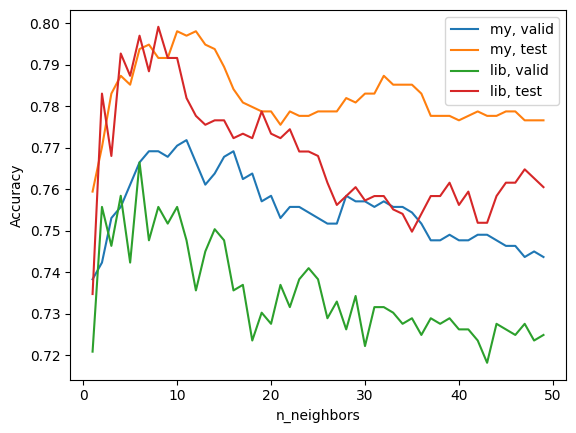

In [16]:
my_val, my_test, lib_val, lib_test = [], [], [], []
for k in tqdm.tqdm(range(1, 50)):
    model = KNN(window_param=k, metric="cosine", kernel="triang")
    model.fit(X_train, y_train)
    my_pred_valid = model.predict(X_valid)[0]
    my_pred_test = model.predict(X_test)[0]

    model = KNeighborsClassifier(k, metric="cosine")
    model.fit(X_train, y_train)
    lib_pred_valid = model.predict(X_valid)
    lib_pred_test = model.predict(X_test)

    my_val.append(accuracy_score(y_valid, my_pred_valid))
    my_test.append(accuracy_score(y_test, my_pred_test))
    lib_val.append(accuracy_score(y_valid, lib_pred_valid))
    lib_test.append(accuracy_score(y_test, lib_pred_test))

plt.plot(list(range(1, 50)), my_val, label='my, valid')
plt.plot(list(range(1, 50)), my_test, label='my, test')
plt.plot(list(range(1, 50)), lib_val, label='lib, valid')
plt.plot(list(range(1, 50)), lib_test, label='lib, test')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend()

In [17]:
def get_weights(X, y, kernel_function, metric_function):
    num_samples = X.shape[0]
    weights = []

    knn = KNN(metric=metric_function, kernel=kernel_function, window_param=3)

    for index in range(num_samples):
        train_X = np.concatenate((X[:index], X[index + 1:]))
        train_y = np.delete(y, index)

        knn.fit(train_X, train_y)

        arr = np.array([X[index]])
        probability = knn.predict(arr)[1][0]
        correct_class_probability = probability[y[index]]

        current_weight = knn._kernel(correct_class_probability)
        weights.append(current_weight)

    return weights


In [18]:
for kernel in ["gaussian", "uniform", "triang", "cosine"]:
    weights = get_weights(X_train, y_train, kernel, metric_function="euclidean")

    model = KNN()
    model.fit(X_train, y_train)
    y_pred_valid1 = model.predict(X_valid)[0]
    y_pred_test1 = model.predict(X_test)[0]

    model = KNN(weights=weights)
    model.fit(X_train, y_train)
    y_pred_valid2 = model.predict(X_valid)[0]
    y_pred_test2 = model.predict(X_test)[0]
    print("without weights", accuracy_score(y_valid, y_pred_valid1), accuracy_score(y_test, y_pred_test1))
    print(kernel, accuracy_score(y_valid, y_pred_valid2), accuracy_score(y_test, y_pred_test2))
    print()

without weights 0.7463087248322148 0.7765843179377014
gaussian 0.6966442953020134 0.7443609022556391

without weights 0.7463087248322148 0.7765843179377014
uniform 0.661744966442953 0.6766917293233082

without weights 0.7463087248322148 0.7765843179377014
triang 0.6389261744966444 0.6713211600429646

without weights 0.7463087248322148 0.7765843179377014
cosine 0.5946308724832214 0.6326530612244898



In [19]:
def get_indexes(X, y, kernel_function, metric_function):
    num_samples = X.shape[0]
    indexes = []

    knn = KNN(metric=metric_function, kernel=kernel_function, window_param=3)

    for index in range(num_samples):
        train_X = np.concatenate((X[:index], X[index+1:]))
        train_y = np.delete(y, index)

        knn.fit(train_X, train_y)

        arr = np.array([X[index]])
        probability = knn.predict(arr)[1][0]
        correct_class_probability = probability[y[index]]

        current_weight = knn._kernel(correct_class_probability)
        if current_weight > 0.1:
            indexes.append(index)

    return indexes


In [20]:
for kernel in ["gaussian", "uniform", "triang", "cosine"]:
    indexes = get_indexes(X_train, y_train, kernel, "manhattan")

    model = KNeighborsClassifier(n_neighbors=27, metric="manhattan")
    model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    print("without weights", accuracy_score(y_valid, y_pred_valid), accuracy_score(y_test, y_pred_test))

    model = KNeighborsClassifier(n_neighbors=27, metric="manhattan")
    model.fit(X_train[indexes], y_train[indexes])
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    print(kernel, accuracy_score(y_valid, y_pred_valid), accuracy_score(y_test, y_pred_test))
    print()

without weights 0.7597315436241611 0.7819548872180451
gaussian 0.7691275167785235 0.7883995703544576

without weights 0.7597315436241611 0.7819548872180451
uniform 0.687248322147651 0.6885069817400644

without weights 0.7597315436241611 0.7819548872180451
triang 0.7140939597315437 0.7056928034371643

without weights 0.7597315436241611 0.7819548872180451
cosine 0.7610738255033557 0.7808807733619764

